### Экспериментальное исследование алгоритмов для регулярных запросов

##### Постановка задачи:
В работе исследуется задача вычисления достижимости в графе с регулярными ограничениями на пути между вершинами. Рассматриваются два подхода: вычисление для всех пар вершин и для выбранного множества стартовых вершин.

Цель эксперимента — оценить производительность алгоритмов `tensor_based_rpq` и `ms_bfs_based_rpq` при различных размерах стартового множества.

Ключевые вопросы исследования:
- Какое представление разреженных матриц является наиболее эффективным для каждого из рассматриваемых сценариев решения?
- Начиная с какого размера множества стартовых вершин становится выгоднее решать задачу достижимости для всех пар вершин и выбирать нужные результаты?



##### Описание исследуемых решений:

Оба алгоритма возвращают пары вершин, соединённых путями, удовлетворяющими заданному регулярному выражению.

- `tensor_based_rpq` — алгоритм на основе тензорного произведения. 
    - Строится DFA для регулярного выражения, граф преобразуется в NFA.
    - Выполняется тензорное произведение автоматов.
    - Вычисляется транзитивное замыкание полученной матрицы смежности.
    - Из матрицы извлекаются пары стартовых и конечных вершин.
- `ms_bfs_based_rpq` — в основе алгоритма лежит итеративное распространение множества достижимых состояний без построения автомата-пересечения и без вычисления транзитивного замыкания:
    - Строится DFA для регулярного выражения regex, входной граф преобразуется в NFA. 
    - тут описание алгоритма


#### Описание набора данных для экспериментов:

##### Запросы:
Для экспериментов использовались регулярные выражения, включающие все основные операции: конкатенацию, альтернативу, звезду Клини.
Используемые выражения:
1. `(a | b)* c d+`,
2. `a (b | c)* d+`,
3. `((a | b)+ c)* d`,
4. `((c+) | a) b d*`

где a, b, c, d соответствуют четырём наиболее часто встречающимся меткам рёбер в графах.


##### Графы:
Для экспериментов использовались три графа из набора CFPQ_data:

| Название графа | Вершины | Рёбра | 
| -------------- | ------- | ----- | 
| travel         | 131     | 277   |
| wine           | 733     | 1839  |
| funding        | 778     | 1086  | 

Выбор обусловлен следующими соображениями:
- Количество вершин и рёбер позволяет выполнить 25 запусков для каждой конфигурации эксперимента за разумное время (на тестовой машине это заняло чуть более 11 часов).
- travel — самый маленький по размеру граф, был выбран для проверки корретности реализации и отладки. 
- wine и funding имеют сопоставимое количество вершин (733 и 778), но существенно различаются по числу рёбер (1839 и 1086), что приводит к различной плотности матриц смежности. Это позволяет протестировать алгоритмы как на более плотных, так и на более разреженных структурах данных, что расширяет диапазон покрываемых сценариев.
- Наличие не менее четырёх различных меток — из-за выбранных регулярных выражений.

#### Описание эксперимента:


##### Оборудование:

##### Что и как замерялось, как эти измерения должны помочь ответить на поставленные вопросы: 
Эксперимент был направлен на то, чтобы количественно оценить, как на время выполнения алгоритмов влияют:
- используемый алгоритм (`tensor_based_rpq` или `ms_bfs_based_rpq`),
- тип представления разреженной матрицы (`csr_matrix`, `csc_matrix`, `lil_matrix`, `coo_matrix`),
- размер множества стартовых вершин,
- характеристики входного графа и регулярное выражение.

Каждое сочетание этих параметров рассматривалось как отдельная конфигурация эксперимента. Для каждой конфигурации алгоритм запускался 25 раз. Все результаты сохранялись в один CSV-файл.



In [1]:
import sys
import os

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), ".."))
from project.graph_utils import get_graph_data, get_graph_by_name
from project.regular_path_query import tensor_based_rpq, ms_bfs_based_rpq
from scipy import sparse
import cfpq_data

import sources directory


In [2]:
MATRIX_TYPES = [
    sparse.csr_matrix,
    sparse.csc_matrix,
    sparse.lil_matrix,
    sparse.coo_matrix,
]

ALGORITHMS = [tensor_based_rpq, ms_bfs_based_rpq]
RUN_COUNT = 25
START_SET_FRACTIONS = [1, 0.7, 0.5, 0.3, 0.1]

In [3]:
def generate_start_set(graph, fraction):
    if fraction == 1:
        return set()
    nodes_count = max(1, int(graph.number_of_nodes() * fraction))
    return cfpq_data.generate_multiple_source(graph, nodes_count, seed=52)


def label_set_to_regexes(labels):
    a = labels[0]
    b = labels[1]
    c = labels[2]
    d = labels[3]
    return (
        f"({a} | {b})* {c} {d}+",
        f"{a} ({b} | {c})* {d}+",
        f"(({a} | {b})+ {c})* {d}",
        f"(({c}+) | {a}) {b} {d}*",
    )

In [4]:
gtravel = get_graph_by_name("travel")
gwine = get_graph_by_name("wine")
gfunding = get_graph_by_name("funding")
GRAPHS = {"travel": gtravel, "wine": gwine, "funding": gfunding}

[2025-10-12 01:20:15]>INFO>Found graph with name='travel'
[2025-10-12 01:20:15]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:15]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:15]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:15]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:15]>INFO>Found graph with name='wine'
[2025-10-12 01:20:15]>INFO>Load archive graph_

In [5]:
REGEXES = {}


def generate_regexes(gname):
    # getting most popular 4 labels
    labels_set = get_graph_data(gname).attributes
    popular_labels = sorted(labels_set)[:4]
    return label_set_to_regexes(popular_labels)


for gname, _ in GRAPHS.items():
    REGEXES[gname] = generate_regexes(gname)

[2025-10-12 01:20:22]>INFO>Found graph with name='travel'
[2025-10-12 01:20:22]>INFO>Load archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:22]>INFO>Unzip graph name='travel' to file graph=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:22]>INFO>Remove archive graph_archive=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2025-10-12 01:20:22]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11ed0d0f0> from path=PosixPath('/Users/vicat/Study/uni/fifth/formal-lang-course/formlang/lib/python3.13/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2025-10-12 01:20:22]>INFO>Found graph with name='wine'
[2025-10-12 01:20:22]>INFO>Load archive graph_

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from itertools import product

In [13]:
OUTPUT_DIR = "experiment_out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RESULTS_CSV = os.path.join(OUTPUT_DIR, "experiment_res.csv")

In [14]:
def measure_time(graph, regex, start_nodes, matrix_type, algo):
    t0 = time.perf_counter()
    try:
        algo(
            regex=regex,
            graph=graph,
            start_nodes=start_nodes,
            final_nodes=set(graph.nodes()),
            matrix_class=matrix_type,
        )
    except Exception as e:
        print(f"ERROR in algo call: {e}")
        print(f"Algo details: {algo}")
        raise

    t1 = time.perf_counter()
    return t1 - t0


def run_experiment_for_graph(gname, graph):
    results = []
    for frac in START_SET_FRACTIONS:
        start_nodes = generate_start_set(graph, frac)
        for run in range(RUN_COUNT):
            for matrix_type, algo, regex in product(
                MATRIX_TYPES, ALGORITHMS, REGEXES[gname]
            ):
                matrix_type_name = matrix_type.__name__
                algo_name = algo.__name__
                elapsed = measure_time(graph, regex, start_nodes, matrix_type, algo)
                record = {
                    "graph": gname,
                    "regex": regex,
                    "matrix_type": matrix_type_name,
                    "algorithm": algo_name,
                    "fraction": frac,
                    "run": run,
                    "time": elapsed,
                    "start_set_size": len(start_nodes),
                }
                results.append(record)

                df = pd.DataFrame([record])
                df.to_csv(RESULTS_CSV, mode="a", index=False, header=False)
    return results


def run_all_experiments():
    all_results = []
    for gname, graph in GRAPHS.items():
        gresults = run_experiment_for_graph(gname, graph)
        all_results.extend(gresults)

    return pd.DataFrame(all_results)

In [16]:
df_results = run_all_experiments()

[2025-10-12 01:32:18]>INFO>Generate set of source vertices of 91 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:34:26]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:35:50]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 01:36:44]>INFO>Generate set of source vertices of 13 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x11edc5400> for multiple-source evaluation
[2025-10-12 03:55:24]>INFO>Generate set of source vertices of 513 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x1068656d0> for multiple-source evaluation
[2025-10-12 05:03:48]>INFO>Generate set of source vertices of 366 nodes for graph=<networkx.classes.mult

[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


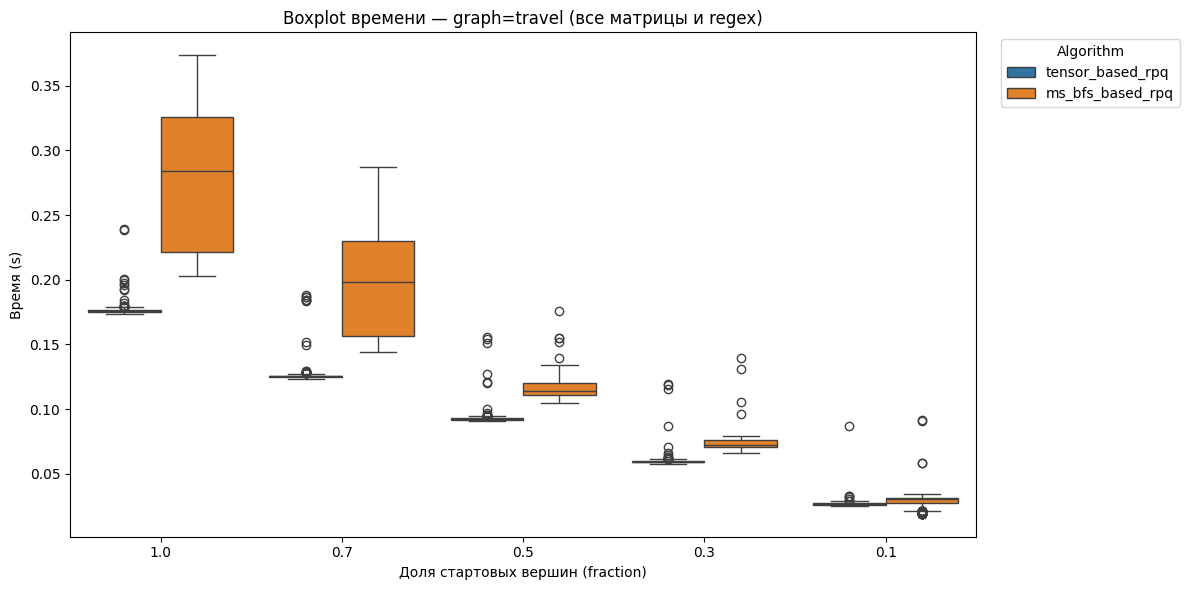

[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


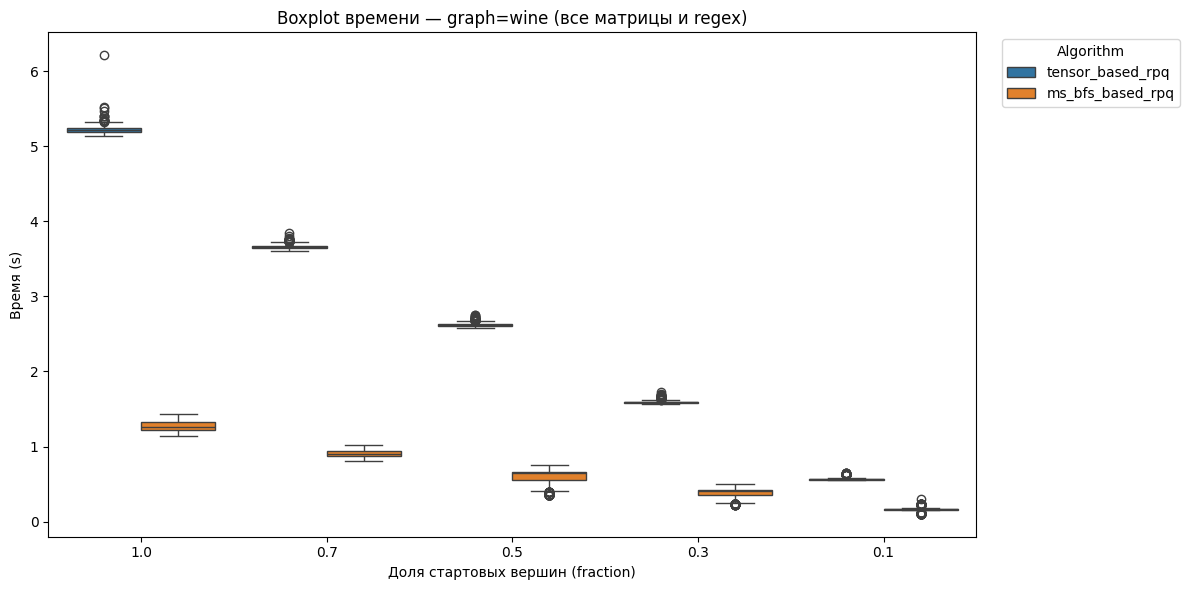

[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2025-10-12 18:16:13]>INFO>Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


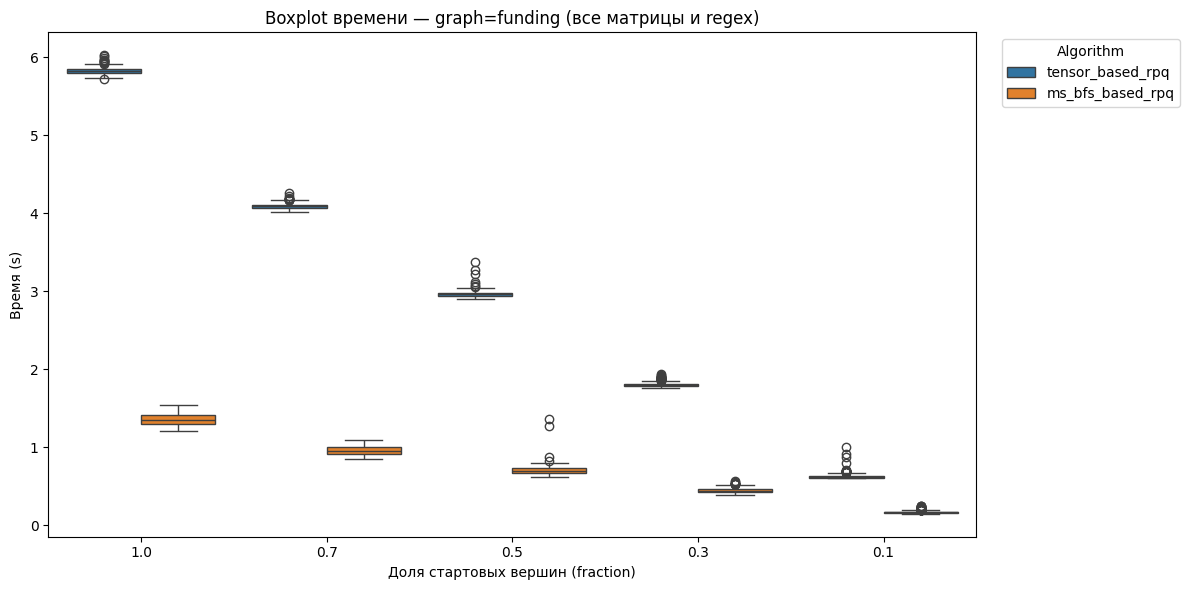

In [ ]:
def plot_boxplots(df, gname, figsize=(14, 6)):
    dfg = df[(df["graph"] == gname)].copy()
    fraction_order = sorted(dfg["fraction"].unique(), reverse=True)

    plt.figure(figsize=figsize)
    ax = sns.boxplot(
        data=dfg,
        x="fraction",
        y="time",
        hue="algorithm",
        order=fraction_order,
        showfliers=True,
    )
    ax.set_title(f"Boxplot времени — graph={gname} (все матрицы и regex)")
    ax.set_ylabel("Время (s)")
    ax.set_xlabel("Доля стартовых вершин (fraction)")
    plt.legend(title="Algorithm", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    return ax


for g in df_results["graph"].unique():
    plot_boxplots(df_results, gname=g, figsize=(12, 6))
    plt.show()